In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model50 as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
import interior

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [4]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']


# without curtain and windows
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [5]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 0, 10: 8, 11: 6, 12: 0, 13: 7, 14: 5, 15: 8, 16: 0, 17: 9, 18: 10, 19: 11, 20: 0, 21: 12, 22: 0, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [6]:

TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into me

Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done

Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done

4327


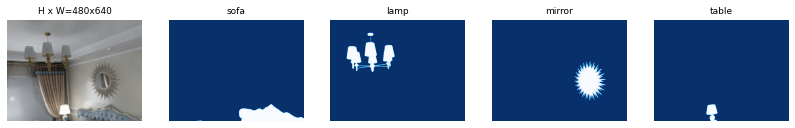

1156


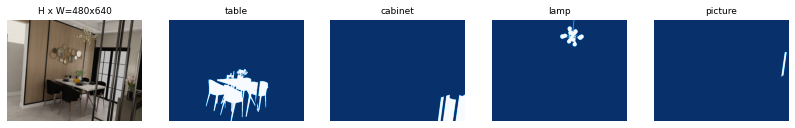

1762


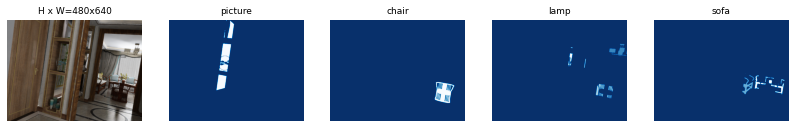

1334


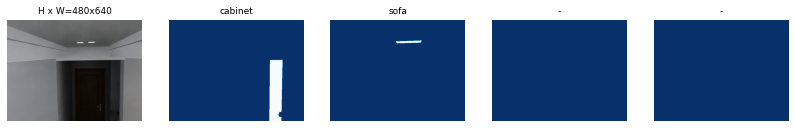

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
print(dataset_train.image_ids)

[   0    1    2 ... 9323 9324 9325]


In [9]:
class TrainConfig(interior.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    BACKBONE = 'resnet50'   
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -0.5
    vmax = 0.5
    nvox = 100
    nvox_z = 3
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 64
    min_z = 1.0
    max_z = 3.0
    NUM_VIEWS = 1
    CONV = True
    USE_RPN_ROIS = True

config_stage1 = TrainConfig()
config_stage1.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
CONV                           True
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                35
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config_stage1,
                          model_dir=MODEL_DIR)
model_path = model.find_last()
model.load_weights(model_path, by_name=True)

# Load pretrained weights
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])

P2_shape: [None, None, None, 256]
P2_type: <class 'tensorflow.python.framework.ops.Tensor'>
feature_map_rpn: [None, None, None, 256]
feature_map_rpn2: <class 'tensorflow.python.framework.ops.Tensor'>
rpn_class_logits_rpn: [None, None, 2]
rpn_probs: [None, None, 2]
rpn_bbox: [None, None, 4]
Re-starting from epoch 3


In [12]:
# This schedule overwrites the learning rate in config
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)


In [13]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=MODEL_DIR, histogram_freq=1)


In [14]:
# Add all callbacks to list
callbacks_list = [lrate]
# from keras.backend.tensorflow_backend import set_session
# config_tf = tf.ConfigProto()
# config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config_tf)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [15]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess= tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)


In [ ]:
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# model_path = 
# model.load_weights(model_path, by_name=True)

print("Fine tune all layers")
model.train(dataset_train, dataset_train,
            learning_rate=config_stage1.LEARNING_RATE, custom_callbacks=callbacks_list,
            epochs=500,
            layers='all')


In [ ]:
image_t, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    modellib.load_image_gt(dataset_train, config_stage1, 10, augment=False,
                                  augmentation=None,
                                  use_mini_mask=config_stage1.USE_MINI_MASK)

In [ ]:
plt.imshow(image_t)
plt.imshow(gt_masks[:,:,0])
print(gt_boxes)

In [ ]:
# Training - Stage 2
# change BATCH_SIZE to 1 and iterations per epoch to 2000
class TrainConfig2(TrainConfig):
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    

config_stage2 = TrainConfig2()
config_stage2.display()
# model_path = model.find_last()
# print(model_path)
model = modellib.MaskRCNN(mode="training", config=config_stage2,
                          model_dir=MODEL_DIR)
# model.load_weights(model_path, by_name=True)
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config_stage2.LEARNING_RATE, custom_callbacks=callbacks_list,
            epochs=1000,
            layers='4+')



In [ ]:
# This schedule overwrites the leraning rate in config
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

In [ ]:
# Add all callbacks to list
callbacks_list = [lrate]

In [ ]:
class TrainConfig2(TrainConfig):
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    

config_stage2 = TrainConfig2()
config_stage2.display()
# model_path = model.find_last()
# print(model_path)
model = modellib.MaskRCNN(mode="training", config=config_stage2, 
                          model_dir=MODEL_DIR)
# model.load_weights(model_path, by_name=True)
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_train,
            learning_rate=config_stage2.LEARNING_RATE / 10, custom_callbacks=callbacks_list,
            epochs=500,
            layers='all')

In [ ]:
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_interior.h5")
model.keras_model.save_weights(model_path)

In [ ]:
class InferenceConfig(interior_seq.InteriorNetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(selected_classes)  # background + num classes    DETECTION_MIN_CONFIDENCE = 0
    vmin = -0.5
    vmax = 0.5
    nvox = 100
    nvox_z = 3
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 64
    min_z = 1.0
    max_z = 3.0
    NUM_VIEWS = 2
    CONV = True
    USE_RPN_ROIS = True
config = InferenceConfig()
config.display()

with tf.device("/gpu:0"):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)

model_path = model.find_last()
print(model_path)
# Load weights trained on MS-COCO
model.load_weights(model_path, by_name=True)

In [ ]:
path = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/test/3FO4MLNLVIOK_Bedroom/cam0/data/14.png'
SAVE_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/Results/'

# image_ids = np.random.choice(dataset_train.image_ids, 20)
image_ids = np.arange(1)
image_pairs = image_ids.reshape([-1,2])
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_train.K
    for image_id in image_pair:
        im.append(dataset_train.load_image(image_id))
        Rcam.append(dataset_train.load_R(image_id))
    results = model.detect([im], [Rcam], [Kmat])
    r = results[0]
    visualize.display_instances(im[0], r['rois'], r['masks'], r['class_ids'], 
                                selected_classes, r['scores'])
    visualize.save_image(image_name = image_id, image = im, boxes = r['rois'], masks = r['masks'], class_ids = r['class_ids'], class_names = selected_classes, scores = r['scores'], save_dir = SAVE_DIR)

